In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
import sqlite3 
import warnings
warnings.filterwarnings("ignore")

## Data Dictionary (primary dataset - brazil medical appointments data)

- **About the dataset**
    - This dataset contains data of around 110k medical appointments in different neighbourhoods of Brazil
    - It describes whether the patient showed up or not for the appointment they booked
    
    
- **Features description**
    - **PatientId** 
        - Unique identification number of a patient
        - Not very useful feature

    - **AppointmentID** 
        - Unique identification of each appointment
        - Not very useful feature

    - **Gender** 
        - Male or Female
        - Binary variable
        - More number of females are present in our dataset as compared to males

    - **ScheduledDay** 
        - The day someone called or registered the appointment, this is before actual appointment date/time
        - Datetime values. includes date and time of appoitnment booking
        - There are same day appintments as well, where schedule day equals appointment day

    - **AppointmentDay** 
        - The day of the actuall appointment, when the patient has to visit the doctor
        - Date values, includes dates only. There is no appointment time

    - **Age** 
        - How old is the patient making the appointment is
        - Values denote numerical age (int)

    - **Neighbourhood** 
        - Where the appointment takes place (area where the hospital / clinic is located)
        - There are 81 unique neighbourhoods available in our dataset
        - String values (object type)

    - **Scholarship** 
        - True of False
        - Observation include weather the patient has access to health scholarshop
        - Details about the scholarship - https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

    - **Hipertension** 
        - True or False
        - Obervation denotes if the patient suffers from hypertention

    - **Diabetes**
        - True or False
        - Obervation denotes if the patient suffers from Diabetes

    - **Alcoholism** 
        - True or False
        - Obervation denotes if the patient suffers from Alcoholism

    - **Handcap**
        - True or False 
        - Observation denotes if the patient is handicapped

    - **SMS_received:** 
        - Obervation denotes if 1 or more reminder messages were sent to the patient before the appointment day

    - **No-show** 
        -   True or False
        - Obervation denotes weather the patient showed up to the apppintment or not
        - Target Variable

## Read the dataset (primary)

In [227]:
## Read the 1st datasource - csv
#df = pd.read_csv('./data/raw_clinic_data.csv')
#print(df_csv.shape)
conn = sqlite3.connect('./dataDB/raw_clinic_data.db')
c = conn.cursor()
df = pd.read_sql_query("SELECT * FROM raw_clinic_data", conn)
print(f'Dataframe Shape: {df.shape}')
df.head()

Dataframe Shape: (110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Initial data cleaning

In [228]:
## Check for datatyes, nul values and column names
df.info()

## Observations
# Total Data points - 110527
# None of the columns have null values
# some data types need to be fixed
# correct target variable for easy interpretation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [229]:
## Checking for unique values
df.nunique()

## Observations
# Appointment id's are unique (no repetetion)
# Patients are 62299 while appointmens are 110527, ie same patients have booked multiple appointments
# There are 81 unique neighbourhoods (for hospitals / medical facilities)
# There are differnt levels of handicap (0 to 4, 5 total)

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

In [230]:
## Fixing observations
# Generalzing column names
df.rename(columns = lambda x : x.lower(), inplace=True)
# Rename columns with spell errors
df.rename(columns={'handcap':'handicap', 'hipertension':'hypertension'}, inplace=True)

## Fixing datatypes
df['appointmentday'] = pd.to_datetime(df['appointmentday'], format='%Y-%m-%d %H:%M:%S')
df['scheduledday'] = pd.to_datetime(df['scheduledday'], format='%Y-%m-%d %H:%M:%S')

## Fixing target variable to make it easy in interpretation
df.rename(columns = {'no-show':"showed"}, inplace=True)
df['showed'] = df['showed'].apply(lambda x: x.lower().replace('no','1')) ## 1 means patient showed up
df['showed'] = df['showed'].apply(lambda x: x.lower().replace('yes','0')) ## 0 means patient did not show up
df['showed'] = df['showed'].astype(int) ## Convert string datatype to integer

df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,showed
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,1


In [231]:
print(f'Total number of records: {len(df)}')

## Checking for unique patients in our dataset
print(f'Number of unique patients: {df.patientid.duplicated().sum()}')

## Checking if there are multiple entries for patient-id and appointment day (if a patient has booked multiple appointments)
count = df[['patientid','appointmentday']].duplicated().sum()
print(f'Patients with multiple appointments on same day: {count}')

## Checking if there are multiple entries for patient-id and appointment_id (if a patient has booked multiple appointments)
count = df[['patientid','appointmentid']].duplicated().sum()
print(f'Patients with multiple entries of same appointments: {count}')

## Observations
# Some patients have multiple appointments on the same day
# But there is no duplication in the appointment
# Each appointment has a unique appointment id

Total number of records: 110527
Number of unique patients: 48228
Patients with multiple appointments on same day: 8719
Patients with multiple entries of same appointments: 0


In [232]:
## Exploring descriptic statistics of our features
df.describe()

## Observations
# feature age has false value (-1)
# there are differnt levels of handicap (0 to 4)

,patientid,appointmentid,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,showed
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.798067
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [233]:
## Fixing observations

# Removing the outliers present in age columns
df = df[df.age != -1]

df.describe()

,patientid,appointmentid,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,showed
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,0.798066
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,0.401445
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [234]:
## Adding new features

# Add a feature to estimate time passed bewteen the appointment booking day and the actual appointment day
# There are observations with days between as 0, means apppintment was booked on same day
df['days_between_appointment_and_scheduled_day'] = (df['appointmentday'].dt.date-df['scheduledday'].dt.date).dt.days

# We dont have exact time of appointment, which means if value of days between < 0, then its an outlier
df = df[ df['days_between_appointment_and_scheduled_day'] >=0 ]
# print( df[['appointmentday']].iloc[27033].dt.date[0], df[['scheduledday']].iloc[27033].dt.date[0])
# df[['appointmentday']].iloc[27033].dt.date[0] - df[['scheduledday']].iloc[27033].dt.date[0]

df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,showed,days_between_appointment_and_scheduled_day
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,1,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0


## EDA

Text(0.5, 1.0, 'Patient ShowUp (vs) No ShowUp')

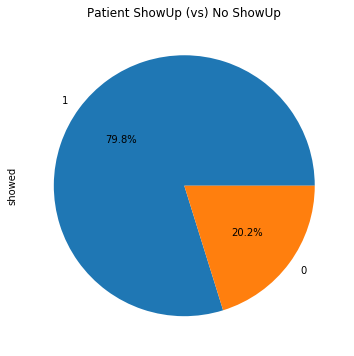

In [235]:
## Pie chart to explore distribution of shows and no shows
df["showed"].value_counts().plot(kind="pie", figsize=(6,6), autopct='%1.1f%%')
plt.title('Patient ShowUp (vs) No ShowUp')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4b16a2150>,
      dtype=object)

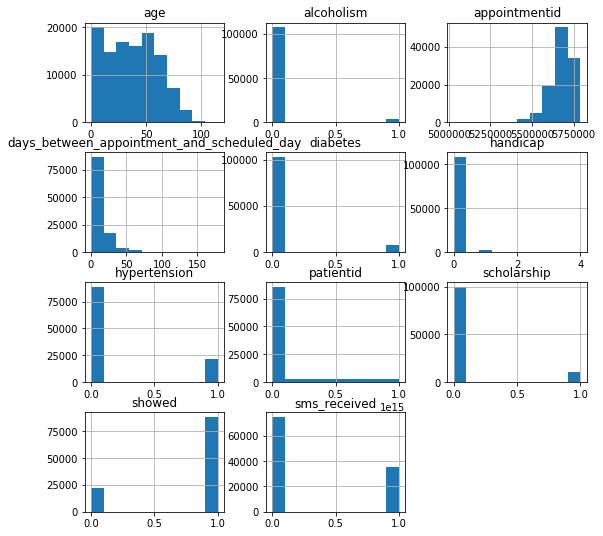

In [236]:
## Display historgrams to look at distributions of all features
df.hist(figsize=(9,9))

In [237]:
# View KDE plot of age and days_between_appointment_and_scheduled_day (continuous features)
#fig,ax = plt.subplots(1,2,figsize=(15,6))
##for i,col in enumerate(['age','days_between_appointment_and_scheduled_day']):
 #   sns.kdeplot(df[col], bw=None, ax=ax[i])
#    ax[i].set_title(col)
#plt.show()

## Observation
# Age is nicely distributed with majority patients in age of 0 to 60 yrs
# We have a lot of infant appointments (new born babies need more care and visits)
# We hace a lot of appointments for ol age people (60-70, old age people require more health checkup)
# days_between_appointment_and_scheduled_day shows mostly appointments had waiting peroid between 0-15 days
# but there were appointments with very long wait ing peroids too (example 180 days)

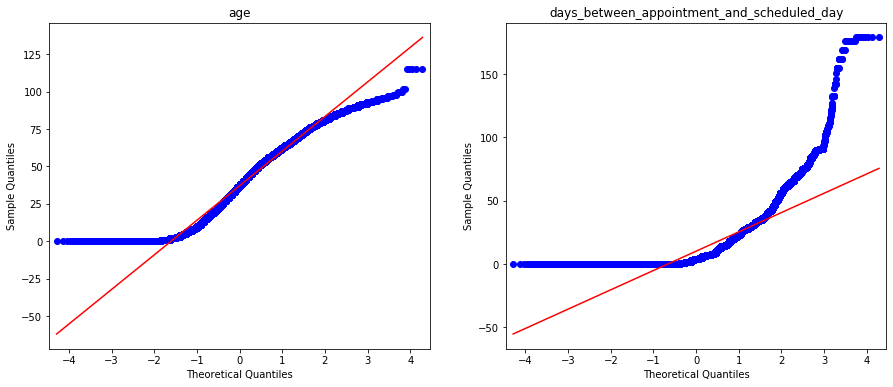

In [238]:
## Checking if we can approximate our continuous variabels by a Gaussian distribution? Useing a Q-Q plot
fig,ax = plt.subplots(1,2,figsize=(15,6))
# Make lineplots for each signal
for i,col in enumerate(['age','days_between_appointment_and_scheduled_day']):
    qqplot(data=df[col],ax=ax[i%2],line='s')
    ax[i%2].set_title(col)
plt.show()

## Observation
# Both the 2 continuous vairables are not very linear in nature 
# hence would be dfficult to approximate them by a gaussian distribution

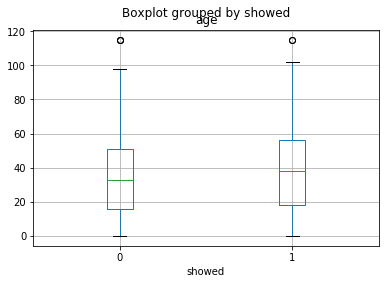

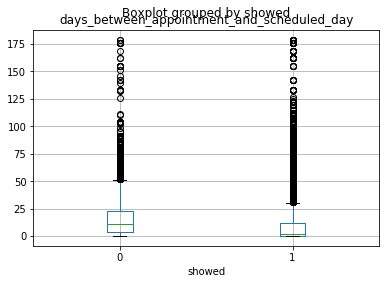

In [239]:
## Visualize the data using a boxplot
#plt.figure(figsize=(10,5))

for i, col in enumerate(['age','days_between_appointment_and_scheduled_day', "showed"]):
    if i !=2:
        df.boxplot(column=col, by='showed')
        ax[i%2].set_title(col)
plt.show()

## Observations
# There are no outliers in age, we just observer one patient who is very old
# days_between_appointment_and_scheduled_day has the most amount of outliers from the rest of the variables

In [240]:
## Explore more about the waiting peroids (high amount of outliers)
# we can not remove outliers from days_between_appointment_and_scheduled_day as there was people who showed up 
# even after long waiting time

print(f'Maximum waiting peroid: {df.days_between_appointment_and_scheduled_day.max()}')
print(f'Minimum waiting peroid: {df.days_between_appointment_and_scheduled_day.min()}')
print(f'Average waiting peroid: {round(df.days_between_appointment_and_scheduled_day.mean(),0)}')
print()

count = len(df.query('days_between_appointment_and_scheduled_day > 150'))
print(f'Patients with waiting peroid > 150: {count}')
count = len(df.query('days_between_appointment_and_scheduled_day > 150 & showed == 1'))
print(f'Patients with waiting peroid > 150 who still showed up: {count}')
print()

count = len(df.query('days_between_appointment_and_scheduled_day > 100'))
print(f'Patients with waiting peroid > 100: {count}')
count = len(df.query('days_between_appointment_and_scheduled_day > 100 & showed == 1'))
print(f'Patients with waiting peroid > 100 who still showed up: {count}')
print()

count = len(df.query('days_between_appointment_and_scheduled_day > 50'))
print(f'Patients with waiting peroid > 50: {count}')
count = len(df.query('days_between_appointment_and_scheduled_day > 50 & showed == 1'))
print(f'Patients with waiting peroid > 50 who still showed up: {count}')


Maximum waiting peroid: 179
Minimum waiting peroid: 0
Average waiting peroid: 10.0

Patients with waiting peroid > 150: 56
Patients with waiting peroid > 150 who still showed up: 38

Patients with waiting peroid > 100: 138
Patients with waiting peroid > 100 who still showed up: 97

Patients with waiting peroid > 50: 3128
Patients with waiting peroid > 50 who still showed up: 2179


Average waiting peroid: 10.0


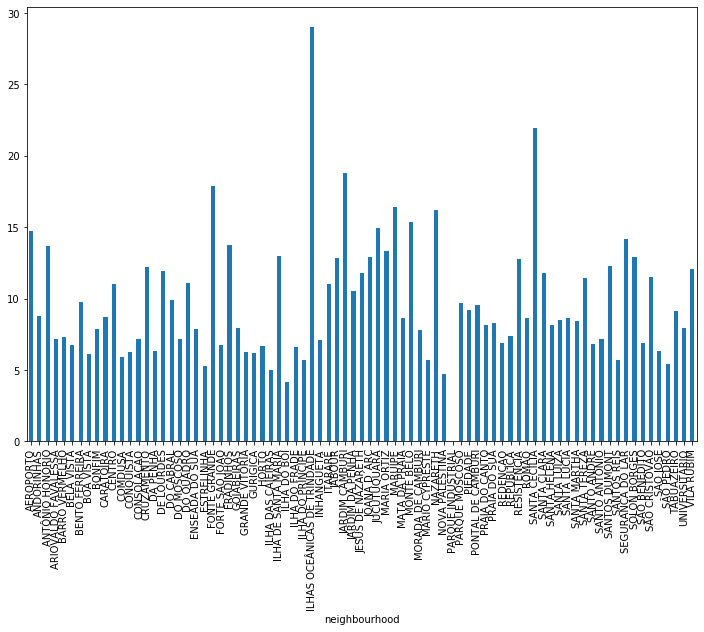

In [241]:
## Exploring if there is any corelation between the long wait time and the neighbourhood
print(f'Average waiting peroid: {round(df.days_between_appointment_and_scheduled_day.mean(),0)}')

# Plot the avg wait time wrt each neighbourhood
waitint_time_by_neighbourhood = df.groupby('neighbourhood').days_between_appointment_and_scheduled_day.mean()
waitint_time_by_neighbourhood.plot(kind='bar',figsize=(12,8))

## Observations
# We observe some neighbourhoods have very high waiting time as compared to an avg of 10 days
# but this plot might be biased as each neighbourhood has different number of patients
# hence percentage or ratio would be a better option


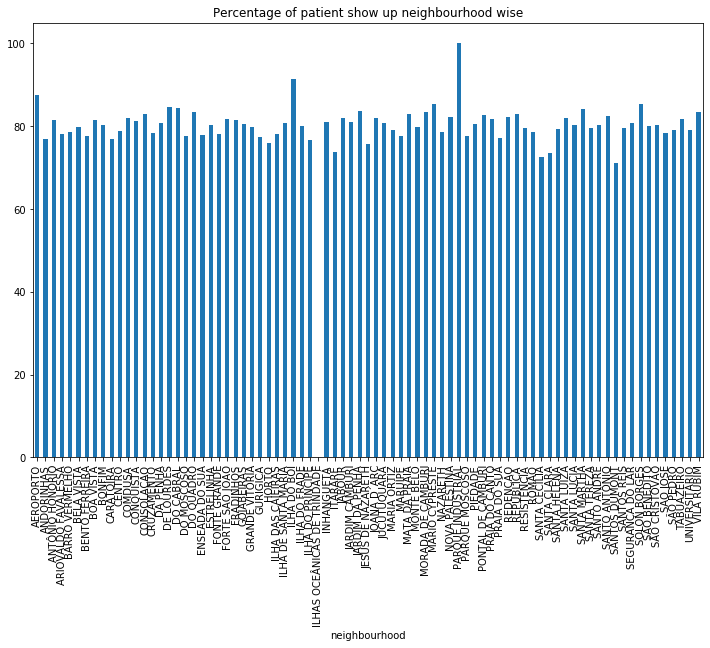

In [242]:
# Get number of patients in each neighbourhood
num_patients_by_neigh = df.groupby('neighbourhood').showed.count()

# Get the count of people who showed up in each neighbourhood
num_patients_showup_by_neigh = df.groupby('neighbourhood').showed.sum()

# Plotting percentage of patient show up neighbourhood wise
percentage_show_up_by_neighbourhood = (num_patients_showup_by_neigh/num_patients_by_neigh) * 100
percentage_show_up_by_neighbourhood.plot(kind="bar", figsize=(12,8),
                                        title="Percentage of patient show up neighbourhood wise")

## Observation
# This indeed is a better way of representation
# but according to the above chart, neighbourhood does not show to be of an effective varibale, 
# because most of the areas very similar show up percentages 
# We still observe 2 primary anomalies - one neighbourhood has 0% show up  and another one has 100%

In [243]:
## furher exploring neighbourhood with 0% show up rate
df.query('neighbourhood == "ILHAS OCEÂNICAS DE TRINDADE"')

# Only 2 patients from this neighbourhood, 
# Both of them did not show up
# Both of them had the same waiting period (29 days)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,showed,days_between_appointment_and_scheduled_day
48754,5.349869e+11,5583947,F,2016-04-14 12:25:43+00:00,2016-05-13 00:00:00+00:00,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,0,29
48765,7.256430e+12,5583948,F,2016-04-14 12:26:13+00:00,2016-05-13 00:00:00+00:00,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,0,29


In [244]:
## furher exploring neighbourhood with 100% show up rate
df.query('neighbourhood == "PARQUE INDUSTRIAL"')

# Only 1 patient from this neighbourhood, and he showed up as well
# No waiting period (0 days)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,showed,days_between_appointment_and_scheduled_day
75199,8.255992e+12,5663947,F,2016-05-05 10:48:59+00:00,2016-05-05 00:00:00+00:00,17,PARQUE INDUSTRIAL,0,0,0,0,0,0,1,0


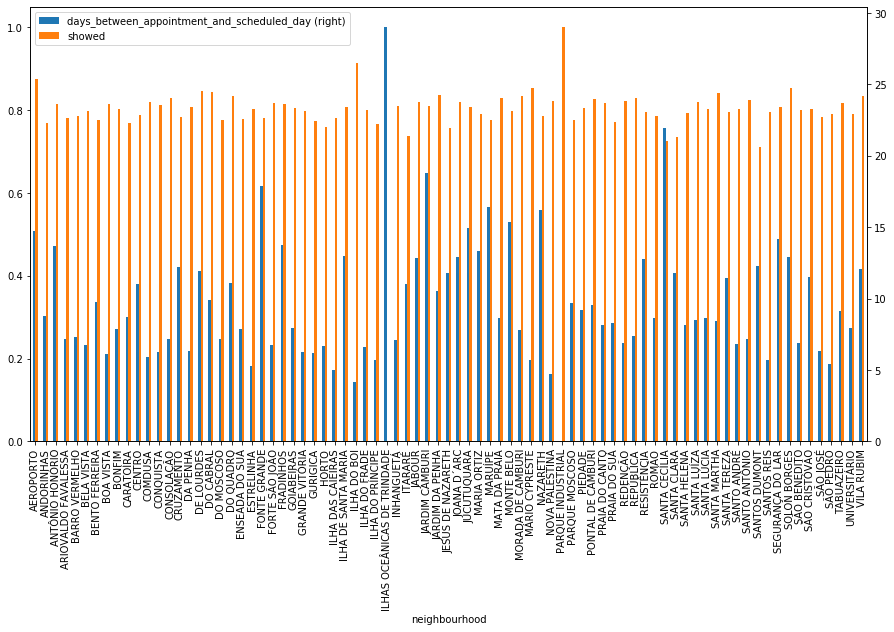

In [245]:
## Exploring Average show rate and avreage waiting days together
avg_show_up_and_wait_time = df.groupby('neighbourhood')[['days_between_appointment_and_scheduled_day','showed']].mean()

#visualisation
avg_show_up_and_wait_time.plot(kind='bar',figsize=(15,8), secondary_y="days_between_appointment_and_scheduled_day")

## Observations
# The neighbourhood that had the highest waiting period had 0 show up rate
# The neighbourhood [PARQUE INDUSTRIAL] with no waiting period showed the max show up

Average waiting peroid: 10.0

Number of patients with LESS than AVG waiting peroid: 76075
Number of patients (ShowedUp) with LESS than AVG waiting peroid: 64961

Number of patients with LONGER than AVG waiting peroid: 34446
Number of patients (ShowedUp) with LONGER than AVG waiting peroid: 23246



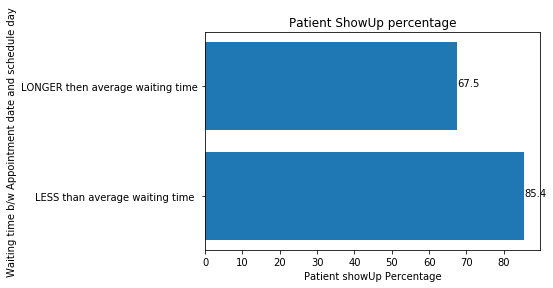

In [246]:
## Checking if high wait peroid has direct relation with higher no show ups

## Average of waiting peroid
avg_waiting_days = round(df.days_between_appointment_and_scheduled_day.mean(), 0)
print(f'Average waiting peroid: {avg_waiting_days}')
print()

## Patients with less than waiting period
less_waiting_days = df.query(f'days_between_appointment_and_scheduled_day <= {avg_waiting_days}')
print(f'Number of patients with LESS than AVG waiting peroid: {less_waiting_days.showed.count()}')
count = less_waiting_days.query('showed == 1').showed.count()
print(f'Number of patients (ShowedUp) with LESS than AVG waiting peroid: {count}')
# Calculating percentage of people who showed up and waiting time less than AVG waiting time
less_waiting_percent = (less_waiting_days.query('showed == 1').showed.count()/less_waiting_days.showed.count())*100
print()

## Patients with longer than waiting period
longer_waiting_days = df.query(f'days_between_appointment_and_scheduled_day > {avg_waiting_days}')
print(f'Number of patients with LONGER than AVG waiting peroid: {longer_waiting_days.showed.count()}')
count = longer_waiting_days.query('showed == 1').showed.count()
print(f'Number of patients (ShowedUp) with LONGER than AVG waiting peroid: {count}')
# Calculating percentage of people who showed up and waiting time longer than AVG waiting time
longer_wait_percent=(longer_waiting_days.query('showed == 1').showed.count()/longer_waiting_days.showed.count())*100
print()

#visualisation
plt.barh(["LESS than average waiting time ", "LONGER then average waiting time"], [less_waiting_percent,longer_wait_percent])
plt.title("Patient ShowUp percentage")
plt.ylabel("Waiting time b/w Appointment date and schedule day")
plt.xlabel("Patient showUp Percentage")
 
for index, value in enumerate([less_waiting_percent,longer_wait_percent]):
    plt.text(value, index, str(round(value,1)))
 
plt.show()

## Observations
# Patients with less than average waiting time were more likely to show up to the appointment
# Patients with longer than average waiting time showed up lesser when compared
# --> higher waiting period is associated with less show-up percentage amoung people

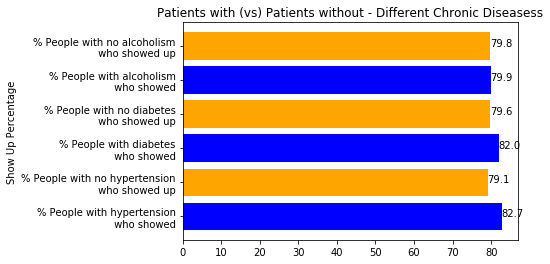

In [247]:
## Exploring relationship b/w chronic diseases and appointments show up

# People with hypertension
hypertension_showup_percent = (df.query('hypertension == 1 & showed == 1').showed.count() / df.query('hypertension == 1').showed.count())*100
no_hypertension_showup_percent = (df.query('hypertension == 0 & showed == 1').showed.count() / df.query('hypertension == 0').showed.count())*100

# People with diabetes
diabetes_showup__percent = (df.query('diabetes == 1 & showed == 1').showed.count() / df.query('diabetes == 1').showed.count())*100
no_diabetes_showup__percent = (df.query('diabetes == 0 & showed == 1').showed.count() / df.query('diabetes == 0').showed.count())*100

# People with alcoholism
alcoholism_showup_percent = (df.query('alcoholism == 1 & showed == 1').showed.count() / df.query('alcoholism == 1').showed.count())*100
no_alcoholism_showup_percent = (df.query('alcoholism == 0 & showed == 1').showed.count() / df.query('alcoholism == 0').showed.count())*100
#calculating the percent of people with no chronic diseases who showed up

non_chronic_percent = (df.query('hypertension == 0 & diabetes == 0 & showed == 1').showed.count() / df.query('hypertension == 0 & diabetes == 0').showed.count())*100

#visulaisation
plt.barh(["% People with hypertension\n who showed", "% People with no hypertension\n who showed up", 
        "% People with diabetes\n who showed", "% People with no diabetes\n who showed up", 
        "% People with alcoholism\n who showed", "% People with no alcoholism\n who showed up"], 
        [hypertension_showup_percent, no_hypertension_showup_percent, 
        diabetes_showup__percent, no_diabetes_showup__percent, 
        alcoholism_showup_percent, no_alcoholism_showup_percent], 
        color = ["blue", "orange","blue", "orange","blue", "orange"])
plt.title("Patients with (vs) Patients without - Different Chronic Diseasess")
plt.ylabel("Show Up Percentage")

for index, value in enumerate([hypertension_showup_percent, no_hypertension_showup_percent, 
        diabetes_showup__percent, no_diabetes_showup__percent, 
        alcoholism_showup_percent, no_alcoholism_showup_percent]):
    plt.text(value, index, str(round(value,1)))

plt.show()

## Observations
# No differences b/w the patients who suffers from alcoholism and who dont
# Mild differnece b/w pateints who have diabestes and hypertention as compared to those who dont

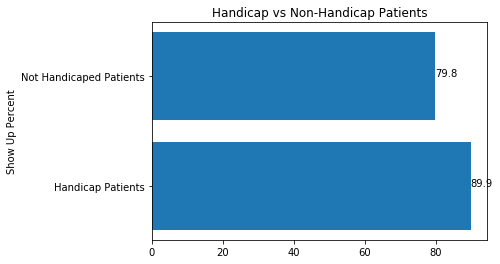

In [248]:
## Exploring relationship b/w people with disability and appointments show up

# Percentage of handicap people who showed up
handicap_percent = (df.query('handicap > 0 & showed == 1').showed.count() / df.query('handicap == 1').showed.count())*100

not_handicap_percent = (df.query('handicap == 0 & showed == 1').showed.count() / df.query('handicap == 0').showed.count())*100

plt.barh(["Handicap Patients", "Not Handicaped Patients"], [handicap_percent, not_handicap_percent])
plt.title("Handicap vs Non-Handicap Patients")
plt.ylabel("Show Up Percent")

for index, value in enumerate([handicap_percent, not_handicap_percent]):
    plt.text(value, index, str(round(value,1)))


# Patients with disabilities showed higher rate of commitment when it comes to showing up for scheduled appointments

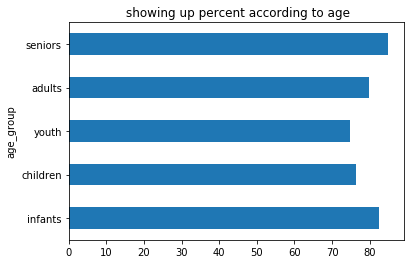

In [249]:
## Exploring relationship of age wrt to apoointments show up

# Different age groups to explore
bin_vals = [0, 3, 15, 25, 60, 115]
age_groups=["infants", "children", "youth", "adults", "seniors"]

# Creates age_group column and add to our dataframe
df['age_group'] = pd.cut(df['age'], bin_vals, labels=age_groups)

# Total number of patients belonging to each age group
age_count_by_group = df.groupby("age_group").showed.count()

# Numbers of pateints who showed up per age group
age_count_by_group_showup = df.groupby('age_group').showed.sum()

# visualisation of the results
((age_count_by_group_showup / age_count_by_group)*100).plot(kind="barh",title=" showing up percent according to age")

## Observations
# Old age and infacts have the maximum show up rate
# while youth has the minimum show up rate amoung all the available age groups

% patients with gender - female who dont show up: 20.311542958962082
% patients with gender - male who dont show up: 19.9638102623756


Text(0.5, 1.0, 'Gender vs ShopUp/NoShowUp')

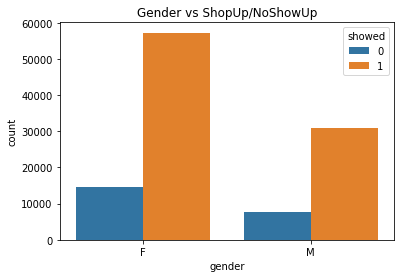

In [250]:
## Exploring relation between gender and appointment showup

women_no_showup_percent = (df.query('gender == "F" & showed == 0').showed.count() / df.query('gender == "F"').showed.count())*100
print(f'% patients with gender - female who dont show up: {women_no_showup_percent}')
men_no_showup_percent = (df.query('gender == "M" & showed == 0').showed.count() / df.query('gender == "M"').showed.count())*100
print(f'% patients with gender - male who dont show up: {men_no_showup_percent}')

sns.countplot(data=df, x="gender",hue="showed")
plt.title("Gender vs ShopUp/NoShowUp")


## Observations
# More women were observed to make appointments as compared to men
# The percentage of male or female patients who dont show up to appointments is approximately same

Number of patients with scholarship: 10861
Number of patients with no scholarship: 99660

Showup % of patients with scholarhsip: 76.26369579228432
Showup % of patients with no scholarhsip: 80.19666867348987


Text(0.5, 1.0, 'Scholarship / No Scholarship (vs) ShopUp / NoShowUp')

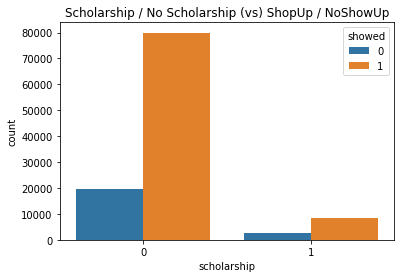

In [251]:
## Exploring relation between availablity of scholarship and appointment showup

# Count of patients with scholarship
count = df.query('scholarship == 1').showed.count()
print(f'Number of patients with scholarship: {count}')
# Count of patients with no scholarship
count = df.query('scholarship == 0').showed.count()
print(f'Number of patients with no scholarship: {count}')
print()

scholarship_percent = (df.query('scholarship == 1 & showed == 1').showed.count() / df.query('scholarship == 1').showed.count())*100
print(f'Showup % of patients with scholarhsip: {scholarship_percent}')
no_scholarship_percent = (df.query('scholarship == 0 & showed == 1').showed.count() / df.query('scholarship == 0').showed.count())*100
print(f'Showup % of patients with no scholarhsip: {no_scholarship_percent}')

sns.countplot(data=df, x="scholarship",hue="showed")
plt.title("Scholarship / No Scholarship (vs) ShopUp / NoShowUp")


## Observations
# Patients with no scholarships have higher show up rate then patients with scholarship

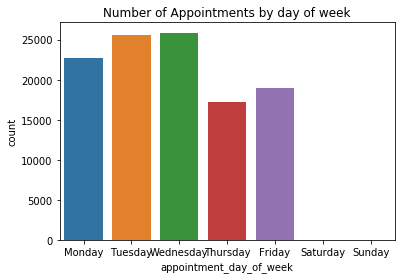

In [252]:
## Explore some datetime features 
weekday_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Extract the day for Appointment Day
df['appointment_day_of_week'] = df['appointmentday'].dt.day_name()


ax = sns.countplot(x=df.appointment_day_of_week, order=weekday_names)
ax.set_title("Number of Appointments by day of week")
plt.show()

## Observations
# We observe that Monday, Tuesday and wednesday see more number of appointments as compared to thurday and friday

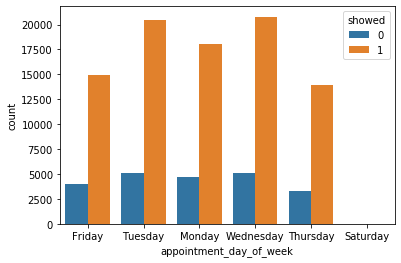

In [253]:
## plot show vs no show by day of week
sns.countplot(data=df, x="appointment_day_of_week",hue="showed")

## Observation

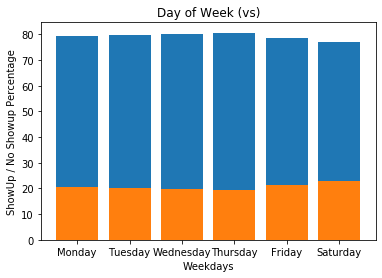

In [254]:
# Get number of patients by weekday
appointments_by_weekday = df.groupby('appointment_day_of_week').agg({"showed": [("total_appintments", "count"), ("showup", "sum")]}).droplevel(0, axis=1) 
appointments_by_weekday["no_showup"] = appointments_by_weekday["total_appintments"] - appointments_by_weekday["showup"]

appointments_by_weekday["showup_percentage"] = round((appointments_by_weekday["showup"] / appointments_by_weekday["total_appintments"])*100, 2)
appointments_by_weekday["no_showup_percentage"] = round((appointments_by_weekday["no_showup"] / appointments_by_weekday["total_appintments"])*100, 2)
appointments_by_weekday = appointments_by_weekday[["showup_percentage", "no_showup_percentage"]]
appointments_by_weekday = appointments_by_weekday.reindex(weekday_names)

plt.bar(list(appointments_by_weekday.index), appointments_by_weekday["showup_percentage"], label = 'ShowUp')
plt.bar(list(appointments_by_weekday.index), appointments_by_weekday["no_showup_percentage"], label = 'No ShowUp')

plt.xlabel("Weekdays")
plt.ylabel("ShowUp / No Showup Percentage")
plt.title("Day of Week (vs)")
plt.show()

## Observation
# The percentage of no show up is slighlty higher on fridays and saturdays

% showup for people who recieved sms reminder: 72.425455160363
% showup for people who did not recieve sms reminder: 83.3020162848652


Text(1, 12.1, '16.7%')

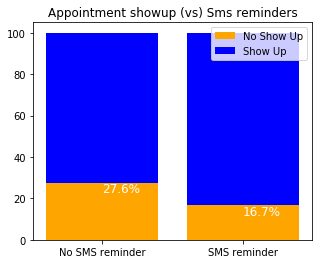

In [255]:
## Explore patient behaviour vs sms reminders

# showup and no showup ratio for patients who recieved sms reminder
sms_recieved_showup = df[df["sms_received"] == 1].showed.mean() * 100
sms_recieved_no_showup = 100 - sms_recieved_showup

# showup and no showup ratio for patients who did not recieve sms reminder
no_sms_recieved_showup = df[df["sms_received"] == 0].showed.mean() * 100
no_sms_recieved_no_showup = 100 -no_sms_recieved_showup

print(f'% showup for people who recieved sms reminder: {sms_recieved_showup}')
print(f'% showup for people who did not recieve sms reminder: {no_sms_recieved_showup}')

plt.figure(figsize=(5,4))

plt.bar([0,1], sms_recieved_no_showup, color="orange")
plt.bar(0, sms_recieved_showup, bottom=sms_recieved_no_showup, color="blue")
plt.bar(1, no_sms_recieved_no_showup, color = "orange")
plt.bar(1, no_sms_recieved_showup, bottom=no_sms_recieved_no_showup, color="blue")
plt.xticks([0, 1], ["No SMS reminder", "SMS reminder"])
plt.legend(["No Show Up", "Show Up"])
plt.title("Appointment showup (vs) Sms reminders")
plt.text(0, 23.2, '{:0.1f}%'.format(sms_recieved_no_showup), color='white', fontsize=12)
plt.text(1, 12.1, '{:0.1f}%'.format(no_sms_recieved_no_showup), color='white', fontsize=12)

## Observations
# Patients who recived SMS reminder showed up more often as compared to patients who did not recieve sms remider
# hence sending remiders does help

## Read and process secondary dataset (weather)

In [256]:
## Read the weather data
df_weather = pd.read_csv("data/weather.csv")

## Convert the date time column to datetime object
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"], format='%Y-%m-%d %H:%M:%S', utc = True)

## Drop irrelevant features
df_weather.drop(columns = ["datetimeEpoch", "precipcover", "preciptype",
                            "snow", "snowdepth", "windgust", "winddir", "pressure",
                            "sunrise", "sunriseEpoch", "sunsetEpoch", "moonphase",
                            "conditions", "description", "icon", "stations", "source",
                            "lat", "log", "sunset"], inplace=True)


## Treating missing values with forward fill
df_weather.ffill(axis = 0, inplace=True)

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 18 columns):
datetime          3440 non-null datetime64[ns, UTC]
tempmax           3440 non-null float64
tempmin           3440 non-null float64
temp              3440 non-null float64
feelslikemax      3440 non-null float64
feelslikemin      3440 non-null float64
feelslike         3440 non-null float64
dew               3440 non-null float64
humidity          3440 non-null float64
precip            3440 non-null float64
precipprob        3440 non-null float64
windspeed         3440 non-null float64
cloudcover        3440 non-null float64
visibility        3440 non-null float64
solarradiation    3440 non-null float64
solarenergy       3440 non-null float64
uvindex           3440 non-null float64
Neighbourhood     3440 non-null object
dtypes: datetime64[ns, UTC](1), float64(16), object(1)
memory usage: 483.9+ KB


In [257]:
## Merge the primary and secondary data
df = df.merge(df_weather, left_on=["appointmentday", "neighbourhood"], right_on=["datetime", "Neighbourhood"], how="left")

## Drop repeated and not required columns
df.drop(columns=["datetime"], inplace=True)


##################################################################################
## Save data for streamlit
#df.to_csv("data/data_for_app.csv", index=False)
## save data(type(DB))
data_for_app_conn = sqlite3.connect('data/data_for_app.db')
c = conn.cursor()
df.to_sql('data_for_app',data_for_app_conn,index =False)
###################################################################################

## Save data to streamlit directory
#df.to_csv("streamlit_app/data/data_for_app.csv", index=False)
streamlit_conn  = sqlite3.connect('streamlit_app/data/data_for_app.db')
c = conn.cursor()
df.to_sql('data_for_app',streamlit_conn,index =False)



##################################################################################
## Drop repeated and not required columns
df.drop(columns=["Neighbourhood", "scheduledday","appointmentday", 'patientid', 'appointmentid'], inplace=True)

## Removing some missing values (check problems)
df.dropna(inplace=True)

df.info()

OperationalError: duplicate column name: Neighbourhood

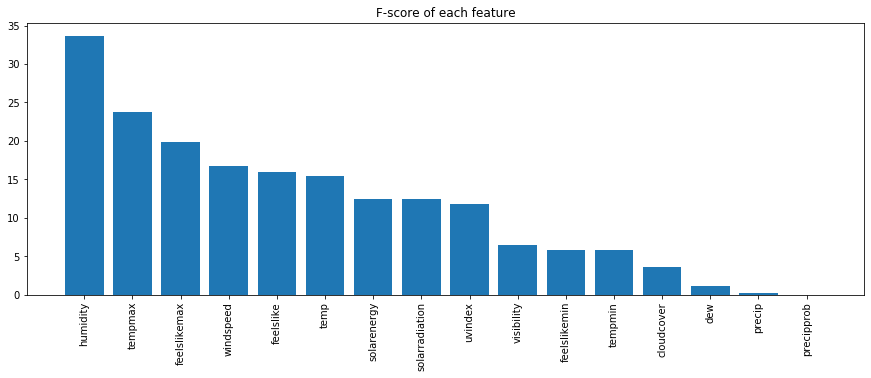

In [ ]:
## Performaing univariate feature selection to select important weather features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_train = df.drop(columns=['gender', 'age', 'neighbourhood', 'scholarship',
       'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received',
       'showed', 'days_between_appointment_and_scheduled_day', 'age_group',
       'appointment_day_of_week'])
y_train = df["showed"]

# Evaluate weather features using ANOVA (score_func = f_classif)
ftest = SelectKBest(score_func=f_classif, k='all')
ftest.fit(X_train,y_train)
f_scores = pd.DataFrame(ftest.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
f_scores = pd.concat([dfcolumns,f_scores],axis=1)
f_scores.columns = ['Feature','F-Score']  
f_scores = f_scores.sort_values(by='F-Score',ascending=False)

# Plot scores
plt.figure(figsize=(15,5))
plt.bar(x=f_scores['Feature'],height=f_scores['F-Score'])
plt.xticks(rotation=90)
plt.title('F-score of each feature')
plt.show()

## Removing features which are not significant
df.drop(columns=['tempmin', 'feelslikemin', 'dew', 'precip', 'precipprob',
                     'cloudcover', 'visibility'], inplace=True)

## Observations
# Humidity, temperature, feels like, windspeed, solar radiation seem to be usefull features for modeling appintment no shows

In [ ]:
## Exploring effect of different weather parameters on patient show ups in each neighbourhood
appointments_weather_df = df.groupby(['neighbourhood','showed'])['tempmax', 'temp', 'feelslikemax',
       'feelslike', 'humidity', 'windspeed', 'solarradiation', 'solarenergy',
       'uvindex'].mean().reset_index()

appointments_weather_df

,neighbourhood,showed,tempmax,temp,feelslikemax,feelslike,humidity,windspeed,solarradiation,solarenergy,uvindex
0,AEROPORTO,0,63.800000,60.700000,63.800000,60.700000,88.600000,8.300000,94.900000,8.300000,4.000000
1,AEROPORTO,1,67.442857,62.114286,67.442857,62.114286,73.500000,12.642857,267.885714,23.157143,8.142857
2,ANDORINHAS,0,78.729077,72.429862,79.944401,72.617485,81.412967,12.200786,156.118271,13.461493,6.013752
3,ANDORINHAS,1,78.739680,72.443179,79.912396,72.605931,81.343416,12.223843,157.499110,13.581554,6.137011
4,ANTÔNIO HONÓRIO,0,83.800000,76.291111,87.051111,77.108889,76.973333,16.111111,170.015556,14.673333,6.200000
...,...,...,...,...,...,...,...,...,...,...,...
154,TABUAZEIRO,1,83.737414,76.323713,87.169234,77.190515,76.723186,16.097122,176.275557,15.200932,6.537900
155,UNIVERSITÁRIO,0,55.550000,46.893750,55.550000,44.356250,87.200000,12.571875,81.946875,7.053125,3.656250
156,UNIVERSITÁRIO,1,55.206723,46.487395,54.919328,43.278992,84.610924,14.505882,89.765546,7.747059,3.941176
157,VILA RUBIM,0,84.399281,76.518705,87.823741,77.402158,75.856835,16.082734,181.975540,15.702878,6.748201


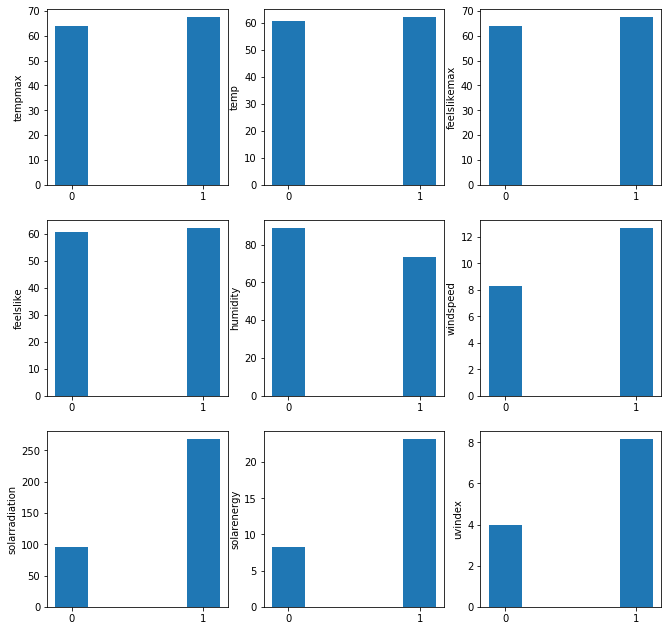

In [ ]:
## No show details
patient_no_show_weather = appointments_weather_df[appointments_weather_df["neighbourhood"] == "AEROPORTO"]
patient_no_show_weather.showed = patient_no_show_weather.showed.astype("str")

fig, axs = plt.subplots(3, 3, figsize=(11, 11))

columns = patient_no_show_weather.columns[2:]
col_idx = 0
for i in range(3):
    for j in range(3):
        axs[i, j].bar(patient_no_show_weather["showed"], patient_no_show_weather[columns[col_idx]], width = 0.25)
        axs[i, j].set_ylabel(columns[col_idx])
        axs[i, j].set_xticks([0, 1], ['No Show', 'Show'])
        col_idx = col_idx + 1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106980 entries, 0 to 110520
Data columns (total 22 columns):
gender                                        106980 non-null object
age                                           106980 non-null int64
neighbourhood                                 106980 non-null object
scholarship                                   106980 non-null int64
hypertension                                  106980 non-null int64
diabetes                                      106980 non-null int64
alcoholism                                    106980 non-null int64
handicap                                      106980 non-null int64
sms_received                                  106980 non-null int64
showed                                        106980 non-null int64
days_between_appointment_and_scheduled_day    106980 non-null int64
age_group                                     106980 non-null category
appointment_day_of_week                       106980 non-null object

In [ ]:
## Adding rating (3rd dataset)
df_locations=pd.read_csv('data/locations.csv')
rating_df=pd.read_csv('data/rating_processed.csv')

## merging ratings data
df=df.merge(df_locations,how='left',left_on=['neighbourhood'],right_on=['locations'])
df=df.merge(rating_df,how='left',on=['lat','lon'])

## Filling missing rating values
df['rating'].fillna(df['rating'].mode()[0], inplace=True)
df['rating'] = round(df['rating'],1)

## Drop not required columns
df.drop(columns=['locations', 'lat', 'lon'], inplace=True)

df.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,showed,...,tempmax,temp,feelslikemax,feelslike,humidity,windspeed,solarradiation,solarenergy,uvindex,rating
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,1,...,75.2,73.3,75.2,73.3,76.7,16.1,52.9,4.3,2.0,4.5
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,1,...,75.2,73.3,75.2,73.3,76.7,16.1,52.9,4.3,2.0,4.5
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,1,...,75.2,73.3,75.2,73.3,76.7,16.1,52.9,4.3,2.0,5.0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,...,75.2,73.3,75.2,73.3,76.7,16.1,52.9,4.3,2.0,5.0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,1,...,75.2,73.3,75.2,73.3,76.7,16.1,52.9,4.3,2.0,4.5


In [ ]:
## Save final processed data for modelling
#f.to_csv("data/final_data_for_modelling.csv", index=False)
##print(df.shape)


final_data_for_modelling  = sqlite3.connect('data/final_data_for_modelling.db')
c = conn.cursor()
df.to_sql('final_data_for_modelling',final_data_for_modelling,index =False)


(106980, 23)


In [ ]:
## write data df to DB

In [ ]:
## Things to do
# 1) Write final dataframe to a sql DB (2 dataframes -> streamlit and modelling)
# 2) Ratings EDA (lilke other params)
# 3) Read all data sources from the database